![NVIDIA Logo](images/nvidia.png)

# Exercise: Apply LoRA to the PubmedQA Task

In this notebook you revisit the PubMedQA question answering task for GPT8B, but this time fine-tuning with LoRA.

---

## Learning Objectives

By the time you complete this notebook you:
- Will be able to perform LoRA fine-tuning.
- Evaluate the performance of a LoRA fine-tuned 8B parameter model on the PubMedQA question answering task.

---

## Imports

In [1]:
import json

from llm_utils.nemo_service_models import NemoServiceBaseModel
from llm_utils.models import LoraModels
from llm_utils.mocks import create_pubmedqa_lora_customization as create_customization
from llm_utils.pubmedqa import strip_response
from llm_utils.helpers import plot_experiment_results

---

## List Models

Here we've gathered the models available for LoRA fine-tuning provided by NeMo Service.

In [2]:
LoraModels.list_models()

gpt8b: gpt-8b-000-lora
gpt43b: gpt-43b-002-lora


---

## LoRA With NeMo Service

If you know how to do p-tuning on the NeMo Service then you can do LoRA. The workflow, including the way data is formatted, is near identical. The only differences in the process between the two are as follows:

1. We need to use a base model that support LoRA rather than p-tuning. `LoraModels` (listed above) contains these 2 models for your convenience.
2. At customization launch time you no longer select for number of virtual tokens, which doesn't make sense in the context of LoRA.
3. At customization launch time you need to select an **adapter dimension**. This is the value `r` in the image below: the rank of the **low-rank matrices**. A typical and good starting point for this value is 32. When using the `create_customization` method the parameter to set this value is `adapter_dim`. `adapter_dim` can be one of `{8, 12, 16, 32, 64}`.

![LoRA](images/lora_medium.png)

---

## Exercise Objective

With that in mind, here is the command we used to run p-tuning using the PubMedQA dataset with the GPT8B model.

```python
conn.create_customization(
    model=PtuneableModels.gpt8b.value,
    name='pubmedqa-8b-token-50-batch-8-epochs-3',
    description="P-tuning for custom pubmedqa model.",
    batch_size=8,
    num_virtual_tokens=50,
    training_dataset_file_id='cb1aab08-e396-41a8-9334-571c6672033d',
    validation_dataset_file_id='42d75e3a-7aa9-46fa-b1c0-63d7a66f7a8f',
    epochs=3
)
```

Your task is to launch a LoRA customization job for the same PubMedQA data using an appropriate GPT8B model. Instead of establishing an actual connection to NeMo Service with `conn.create_customization`, you will use our mock `create_customization` function imported above. If you don't pass in the correct arguments, the function will tell you. When you do successfully provide the correct arguments for the LoRA customization, the function will provide you with a customization ID for a LoRA customization we have already completed, that you will us later in this notebook.

If you get stuck, feel free to check out the solution below.

### Custom Model

In [5]:
create_customization(model='gpt-8b-000-lora',
                     training_dataset_file_id='cb1aab08-e396-41a8-9334-571c6672033d',
                     validation_dataset_file_id='42d75e3a-7aa9-46fa-b1c0-63d7a66f7a8f',
                     adapter_dim=32,
                     epochs=3)

'LoRA customization job for GPT8B succesfully launched! Customization ID: cab8b23d-b49d-4e35-bfad-3abc572d8f09'

In [6]:
customization_id = 'cab8b23d-b49d-4e35-bfad-3abc572d8f09'

---

## Load Test Data

Now that you have `customization_id`, set, let's proceed to load the test data and then evaluating the LoRA customization on it.

In [7]:
prompts_and_answers = json.load(open('data/pubmedqa_panda_test.json','r'))

---

## LoRA Customization Model Instance

Run the cell below to instantiate an instance of the LoRA fine-tuned GPT8B model.

In [8]:
model = NemoServiceBaseModel(model=LoraModels.gpt8b.value, customization_id=customization_id)

---

## Try Zero-shot Prompts With LoRA Fine-tuned Model

In [9]:
for prompt, answer in prompts_and_answers[::45]:
    response = model.generate(prompt, tokens_to_generate=1, return_type='text').strip()
    print(f'Response from model: {response}')
    print(f'Actual answer: {answer}')
    correct = response == answer
    print(f'Response from model correct: {correct}\n')

Response from model: no
Actual answer: no
Response from model correct: True

Response from model: yes
Actual answer: no
Response from model correct: False

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: no
Actual answer: no
Response from model correct: True



So far the LoRA fine-tuned GPT8B model appears to be performing quite well.

---

## Evaluate Performance

Let's run a sanity test on evaluating the model.

In [10]:
model.evaluate(prompts_and_answers[:5],
                get_clean_prediction=strip_response,
                tokens_to_generate=1)

  0%|          | 0/5 [00:00<?, ?it/s]

3/5 correct
Accuracy: 0.60


'0.60'

---

## Zero-shot Prompting With LORA Model on Full Dataset

In [11]:
model.evaluate(prompts_and_answers,
            get_clean_prediction=strip_response,
            write_results_to_csv=True,
            experiment_name='LoRA',
            csv_file_name='experiment_results/pubmed_experiment_results.csv',
            model_description='gpt-8b-000',
            tokens_to_generate=1)

  0%|          | 0/150 [00:00<?, ?it/s]

106/150 correct
Accuracy: 0.71


'0.71'

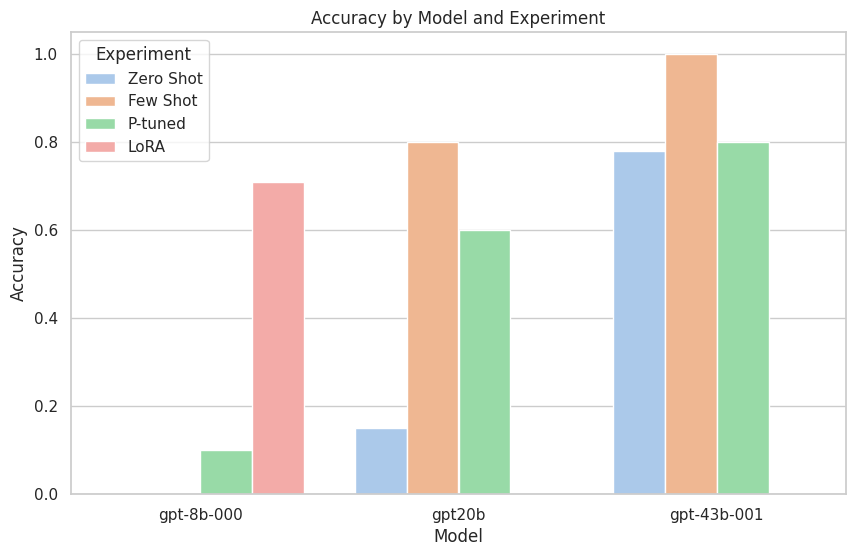

In [12]:
plot_experiment_results('experiment_results/pubmed_experiment_results.csv')


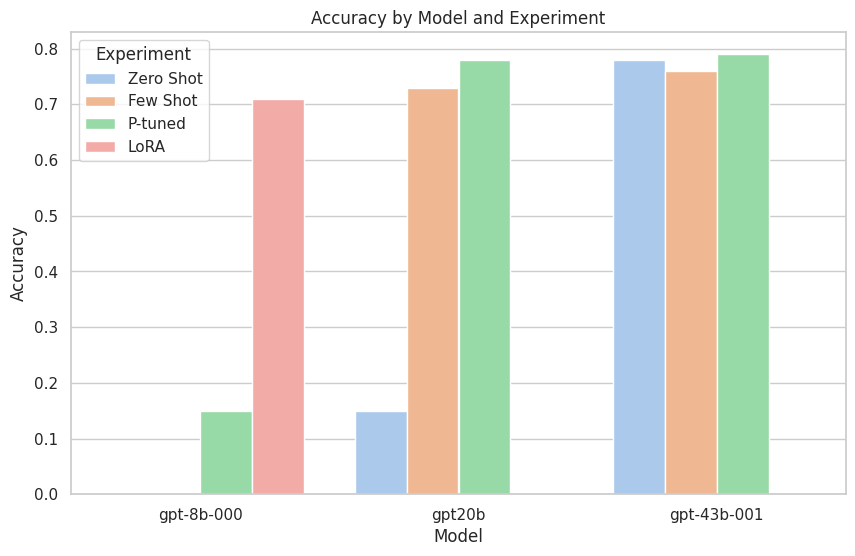

In [13]:
plot_experiment_results('experiment_results/solutions/lora_pubmed_experiment_results.csv')

### Analysis

The GPT8B LoRA fine-tuned model improved drastically! 8B's accuracy is now within 10% of the much larger 20B and 43B models.

When we consider the advantages of using a smaller model, we may find it very worthwhile to give up 10% accuracy. The 8B model is faster, and being smaller is likely much less expensive to maintain, especially over time, due to its reduced GPU memory requirements.

In addition to adding new functionality to models, this is one of the key value propositions for PEFT: moving functionality into smaller, faster, less expensive models.